In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [53]:
# STEP 1: Load the Dataset
print("\nLoading the loan dataset")

# Load dataset 
try:
    df = pd.read_csv('canadian_loan_portfolio.csv')  
    print(f"Successfully loaded your dataset!")
except FileNotFoundError:
    print("Dataset file not found. Please ensure the file is in the same folder")
    exit()

print(f"Loaded portfolio: {len(df):,} loans worth ${df['loan_amount'].sum()/1e6:.0f}M")


Loading the loan dataset
Successfully loaded your dataset!
Loaded portfolio: 1,000 loans worth $151M


In [61]:
# SHOW INFORMATION FROM DATASET
print(f"\nDataset Statistics:")
print(f"Credit Score Range: {df['credit_score'].min()} - {df['credit_score'].max()} (avg: {df['credit_score'].mean():.0f})")
print(f"Income Range: ${df['annual_income'].min():,} - ${df['annual_income'].max():,} (avg: ${df['annual_income'].mean():,.0f})")
print(f"Loan Amount Range: ${df['loan_amount'].min():,} - ${df['loan_amount'].max():,} (avg: ${df['loan_amount'].mean():,.0f})")

print(f"\nLoan Type Distribution:")
print(df['loan_type'].value_counts())

print(f"\nLoan Status Distribution:")
print(df['loan_status'].value_counts())

print(f"\nProvince Distribution:")
print(df['province'].value_counts())


Dataset Statistics:
Credit Score Range: 355.0 - 850.0 (avg: 655)
Income Range: $20,000.0 - $188,986.5 (avg: $40,787)
Loan Amount Range: $5,320 - $299,150 (avg: $151,166)

Loan Type Distribution:
loan_type
Mortgage       422
Auto           299
Personal       186
Credit Line     93
Name: count, dtype: int64

Loan Status Distribution:
loan_status
Current              789
Late (30-59 days)    100
Charged Off           63
Late (60+ days)       48
Name: count, dtype: int64

Province Distribution:
province
ON    407
QC    207
AB    147
BC    146
SK     48
MB     45
Name: count, dtype: int64


In [63]:
# Check for missing values
if df.isnull().sum().sum() > 0:
    print(f"\nMissing Values Found:")
    print(df.isnull().sum())
    # Fill missing values if any
    df = df.fillna(df.median(numeric_only=True))
    print("Missing values handled")


Missing Values Found:
loan_id              0
applicant_name       0
credit_score        40
annual_income        0
loan_amount          0
debt_to_income       0
employment_years     0
loan_type            0
loan_status          0
province             0
application_date     0
dtype: int64
Missing values handled


In [65]:
# STEP 2: Calculate Basel III Risk Metrics
print("\nStep 2: Calculating Basel III risk metrics")

# Convert existing 'Charged Off' to default indicator
df['current_default'] = (df['loan_status'] == 'Charged Off').astype(int)

# Calculate Probability of Default using Basel III approach
def calculate_basel_pd(row):
    """Calculate PD using the data's risk factors"""
    # Credit score factor (higher score = lower PD)
    credit_factor = max(0, (800 - row['credit_score']) / 500)
    
    # Debt-to-income factor  
    dti_factor = min(row['debt_to_income'], 0.8)
    
    # Employment stability factor
    employment_factor = max(0, (15 - row['employment_years']) / 15)
    
    # Combine factors (Basel III weighted approach)
    pd_score = (credit_factor * 0.5 + dti_factor * 0.3 + employment_factor * 0.2)
    
    # Convert to realistic PD range (0.5% to 30%)
    return max(0.005, min(0.30, pd_score * 0.4))

df['probability_of_default'] = df.apply(calculate_basel_pd, axis=1)


Step 2: Calculating Basel III risk metrics


In [67]:
# Loss Given Default by loan type (Basel III regulatory rates)
lgd_rates = {
    'Mortgage': 0.25,      # Secured by property
    'Auto': 0.40,          # Secured by vehicle  
    'Personal': 0.65,      # Unsecured
    'Credit Line': 0.70    # Unsecured revolving
}
df['loss_given_default'] = df['loan_type'].map(lgd_rates)

# Handle any loan types not in the mapping
if df['loss_given_default'].isnull().any():
    df['loss_given_default'] = df['loss_given_default'].fillna(0.50)  # Default LGD

# Exposure at Default (Basel III standard = 95% of loan amount)
df['exposure_at_default'] = df['loan_amount'] * 0.95

# Expected Loss = PD × LGD × EAD (Core Basel III formula)
df['expected_loss'] = df['probability_of_default'] * df['loss_given_default'] * df['exposure_at_default']

# Risk-Weighted Assets (Basel III)
rwa_weights = {'Mortgage': 0.35, 'Auto': 0.75, 'Personal': 1.0, 'Credit Line': 1.0}
df['risk_weight'] = df['loan_type'].map(rwa_weights).fillna(1.0)
df['risk_weighted_assets'] = df['exposure_at_default'] * df['risk_weight']

print(f"Average default probability: {df['probability_of_default'].mean():.2%}")
print(f"Total expected loss: ${df['expected_loss'].sum()/1e6:.1f}M")
print(f"Expected loss rate: {df['expected_loss'].sum()/df['exposure_at_default'].sum():.2%}")
print(f"Total Risk-Weighted Assets: ${df['risk_weighted_assets'].sum()/1e6:.0f}M")

Average default probability: 15.43%
Total expected loss: $9.2M
Expected loss rate: 6.40%
Total Risk-Weighted Assets: $93M


In [69]:
# STEP 3: STRESS TESTING - Economic Downturn
print("\nApplying economic stress test to the portfolio")
print("Scenario: 5% unemployment spike + 3% interest rate increase")

# Create stressed version of the data
df_stress = df.copy()

# Stress parameters 
unemployment_shock = 0.05  # 5% unemployment increase
interest_rate_shock = 0.03  # 3% interest rate increase

# Calculate stress multiplier for PD (research-based)
pd_stress_multiplier = 1 + (unemployment_shock * 15) + (interest_rate_shock * 10)

# Apply stress to the PD calculations
df_stress['stressed_pd'] = df_stress['probability_of_default'] * pd_stress_multiplier
df_stress['stressed_pd'] = df_stress['stressed_pd'].clip(0.005, 0.85)  # Realistic bounds


Applying economic stress test to the portfolio
Scenario: 5% unemployment spike + 3% interest rate increase


In [71]:
# Stress impact on LGD (asset values decline)
lgd_stress_increase = 0.20  # 20% higher LGD during severe downturns
df_stress['stressed_lgd'] = df_stress['loss_given_default'] + lgd_stress_increase
df_stress['stressed_lgd'] = df_stress['stressed_lgd'].clip(0.1, 0.9)

# Calculate stressed expected loss
df_stress['stressed_expected_loss'] = (df_stress['stressed_pd'] * 
                                      df_stress['stressed_lgd'] * 
                                      df_stress['exposure_at_default'])

# Additional capital requirement
df_stress['additional_capital_needed'] = df_stress['stressed_expected_loss'] - df_stress['expected_loss']

print(f"Stressed default probability: {df_stress['stressed_pd'].mean():.2%}")
print(f"Stressed expected loss: ${df_stress['stressed_expected_loss'].sum()/1e6:.1f}M")


Stressed default probability: 31.64%
Stressed expected loss: $27.9M


In [73]:
# STEP 4: Comprehensive Analysis Report
print("BASEL III STRESS TEST RESULTS ");
print("-"*70)

# Calculate key metrics from the data
total_exposure = df['exposure_at_default'].sum() / 1e6
base_loss = df['expected_loss'].sum() / 1e6
stress_loss = df_stress['stressed_expected_loss'].sum() / 1e6
additional_capital = df_stress['additional_capital_needed'].sum() / 1e6
loss_multiplier = stress_loss / base_loss if base_loss > 0 else 0
current_defaults = df['current_default'].sum()

BASEL III STRESS TEST RESULTS 
----------------------------------------------------------------------


In [75]:
print(f"\nSUMMARY:")
print(f"Total Loans: {len(df):,}")
print(f"Total Exposure: ${total_exposure:.0f}M")
print(f"Current Defaults: {current_defaults:,} ({current_defaults/len(df):.1%})")
print(f"Provinces: {df['province'].nunique()} ({', '.join(sorted(df['province'].unique()))})")
print(f"Loan Types: {', '.join(df['loan_type'].unique())}")
print(f"Date Range: {df['application_date'].min()} to {df['application_date'].max()}")

print(f"\nBASEL III RISK ANALYSIS:")
print(f"Average PD (Normal):     {df['probability_of_default'].mean():.2%}")
print(f"Average PD (Stressed):   {df_stress['stressed_pd'].mean():.2%}")
print(f"Average LGD (Normal):    {df['loss_given_default'].mean():.1%}")
print(f"Average LGD (Stressed):  {df_stress['stressed_lgd'].mean():.1%}")
print(f"Total RWA:               ${df['risk_weighted_assets'].sum()/1e6:.0f}M")

print(f"\nSTRESS TEST IMPACT:")
print(f"Normal Expected Loss:    ${base_loss:.1f}M ({base_loss/total_exposure:.2%} of exposure)")
print(f"Stressed Expected Loss:  ${stress_loss:.1f}M ({stress_loss/total_exposure:.2%} of exposure)")
print(f"Additional Loss Risk:    ${stress_loss-base_loss:.1f}M ({(loss_multiplier-1)*100:.0f}% increase)")
print(f"Capital Buffer Needed:   ${additional_capital:.1f}M")


SUMMARY:
Total Loans: 1,000
Total Exposure: $144M
Current Defaults: 63 (6.3%)
Provinces: 6 (AB, BC, MB, ON, QC, SK)
Loan Types: Mortgage, Auto, Personal, Credit Line
Date Range: 2020-01-01 to 2022-09-26

BASEL III RISK ANALYSIS:
Average PD (Normal):     15.43%
Average PD (Stressed):   31.64%
Average LGD (Normal):    41.1%
Average LGD (Stressed):  61.1%
Total RWA:               $93M

STRESS TEST IMPACT:
Normal Expected Loss:    $9.2M (6.40% of exposure)
Stressed Expected Loss:  $27.9M (19.44% of exposure)
Additional Loss Risk:    $18.7M (204% increase)
Capital Buffer Needed:   $18.7M


In [77]:
# Analysis by loan type from the data
print(f"\nIMPACT BY LOAN TYPE:")
print(f"{'Type':<12} {'Count':<6} {'Normal Loss':<12} {'Stress Loss':<12} {'Impact'}")
for loan_type in df['loan_type'].unique():
    mask = df['loan_type'] == loan_type
    count = mask.sum()
    normal_loss = df[mask]['expected_loss'].sum() / 1e6
    stress_loss_type = df_stress[mask]['stressed_expected_loss'].sum() / 1e6
    impact = stress_loss_type - normal_loss
    
    print(f"{loan_type:<12} {count:<6} ${normal_loss:<11.1f} ${stress_loss_type:<11.1f} ${impact:>+6.1f}M")


IMPACT BY LOAN TYPE:
Type         Count  Normal Loss  Stress Loss  Impact
Mortgage     422    $2.3         $8.5         $  +6.2M
Auto         299    $2.6         $7.9         $  +5.3M
Personal     186    $2.8         $7.4         $  +4.6M
Credit Line  93     $1.6         $4.1         $  +2.6M


In [79]:
# Analysis by province from the data
print(f"\nIMPACT BY PROVINCE:")
print(f"{'Province':<8} {'Loans':<6} {'Normal':<10} {'Stressed':<10} {'Impact'}")
for province in sorted(df['province'].unique()):
    mask = df['province'] == province
    count = mask.sum()
    normal = df[mask]['expected_loss'].sum() / 1e6
    stressed = df_stress[mask]['stressed_expected_loss'].sum() / 1e6
    impact = stressed - normal
    
    print(f"{province:<8} {count:<6} ${normal:<9.1f} ${stressed:<9.1f} ${impact:>+6.1f}M")


IMPACT BY PROVINCE:
Province Loans  Normal     Stressed   Impact
AB       147    $1.3       $3.9       $  +2.6M
BC       146    $1.4       $4.1       $  +2.7M
MB       45     $0.4       $1.1       $  +0.8M
ON       407    $3.8       $11.6      $  +7.8M
QC       207    $1.9       $5.8       $  +3.9M
SK       48     $0.4       $1.3       $  +0.9M



Creating charts from the data


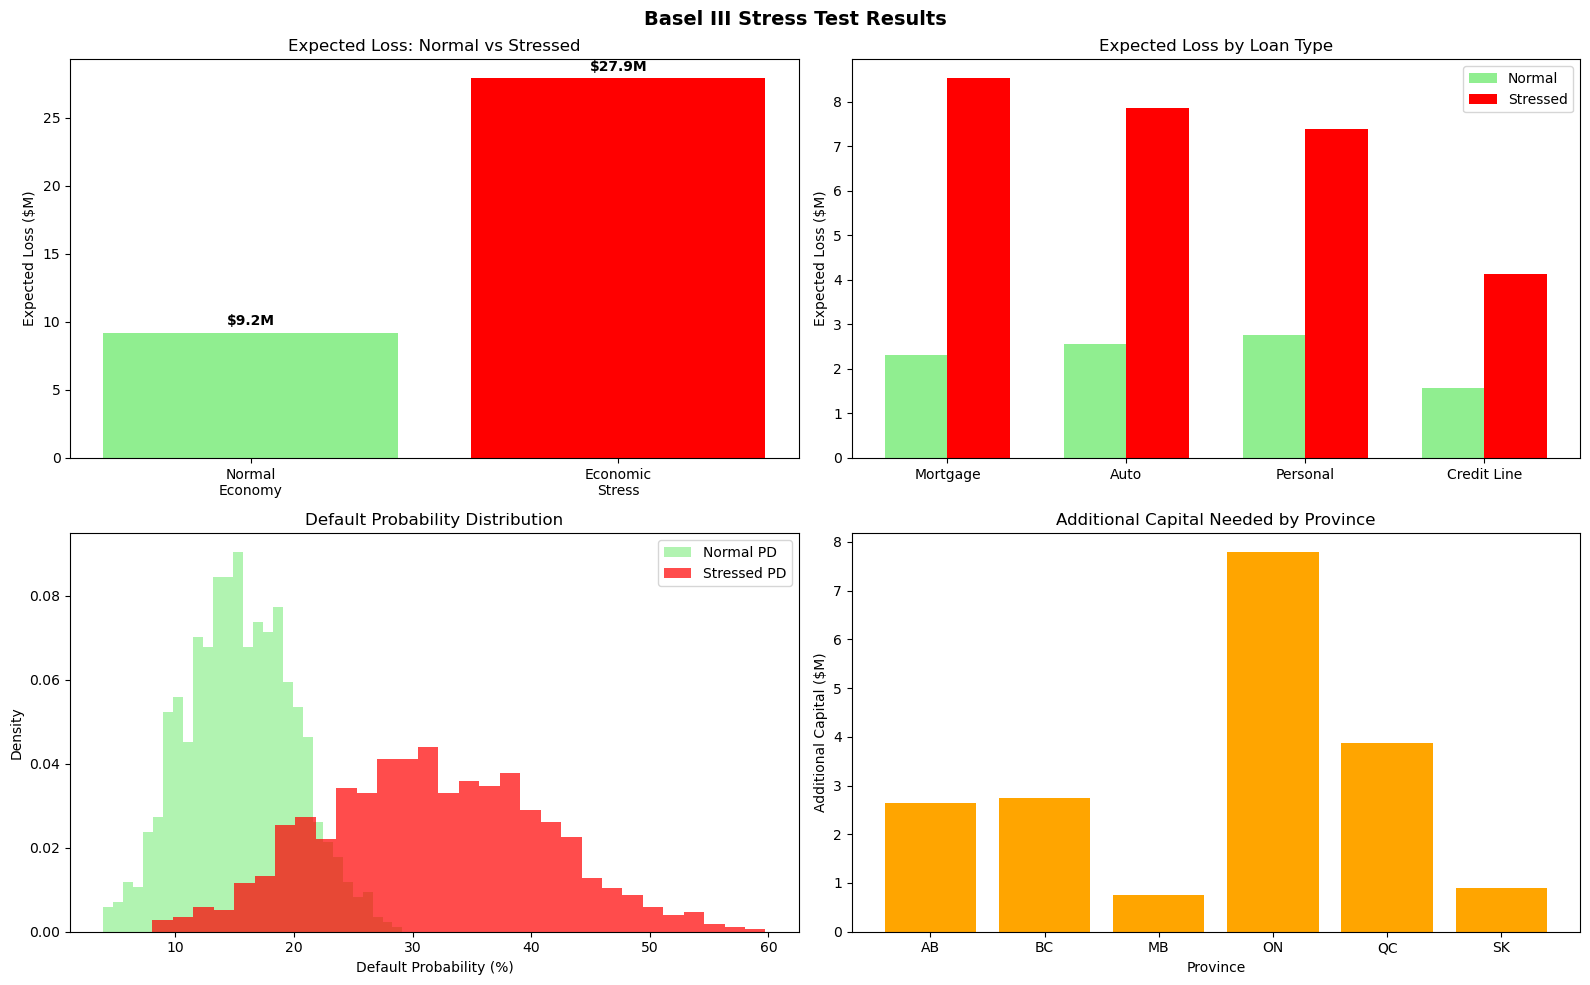

In [83]:
# STEP 5: Create Professional Charts
print(f"\nCreating charts from the data")

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Basel III Stress Test Results', fontsize=14, fontweight='bold')

# Chart 1: Expected Loss Comparison
scenarios = ['Normal\nEconomy', 'Economic\nStress']
losses = [base_loss, stress_loss]
colors = ['lightgreen', 'red']
bars = axes[0,0].bar(scenarios, losses, color=colors)
axes[0,0].set_title('Expected Loss: Normal vs Stressed')
axes[0,0].set_ylabel('Expected Loss ($M)')
for i, (bar, value) in enumerate(zip(bars, losses)):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, value + max(losses)*0.02, 
                   f'${value:.1f}M', ha='center', fontweight='bold')

# Chart 2: Impact by Loan Type 
loan_types = df['loan_type'].unique()
normal_by_type = [df[df['loan_type']==lt]['expected_loss'].sum()/1e6 for lt in loan_types]
stress_by_type = [df_stress[df_stress['loan_type']==lt]['stressed_expected_loss'].sum()/1e6 for lt in loan_types]

x = np.arange(len(loan_types))
width = 0.35
axes[0,1].bar(x - width/2, normal_by_type, width, label='Normal', color='lightgreen')
axes[0,1].bar(x + width/2, stress_by_type, width, label='Stressed', color='red')
axes[0,1].set_title('Expected Loss by Loan Type')
axes[0,1].set_ylabel('Expected Loss ($M)')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(loan_types)
axes[0,1].legend()

# Chart 3: Default Rate Distribution 
axes[1,0].hist(df['probability_of_default']*100, bins=30, alpha=0.7, 
               label='Normal PD', color='lightgreen', density=True)
axes[1,0].hist(df_stress['stressed_pd']*100, bins=30, alpha=0.7, 
               label='Stressed PD', color='red', density=True)
axes[1,0].set_title('Default Probability Distribution')
axes[1,0].set_xlabel('Default Probability (%)')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()

# Chart 4: Provincial Impact 
provinces = sorted(df['province'].unique())
provincial_impact = [df_stress[df_stress['province']==p]['additional_capital_needed'].sum()/1e6 
                    for p in provinces]
bars = axes[1,1].bar(provinces, provincial_impact, color='orange')
axes[1,1].set_title('Additional Capital Needed by Province')
axes[1,1].set_ylabel('Additional Capital ($M)')
axes[1,1].set_xlabel('Province')

plt.tight_layout()
plt.show()

In [87]:
# STEP 6: Export Enhanced Results
print(f"\nExporting enhanced analysis")

# Create enhanced version of the dataset with Basel III calculations
enhanced_df = df[['loan_id', 'applicant_name', 'credit_score', 'annual_income', 'loan_amount', 
                  'debt_to_income', 'employment_years', 'loan_type', 'loan_status', 'province', 
                  'application_date']].copy()

# Add Basel III metrics
enhanced_df['probability_of_default'] = df['probability_of_default']
enhanced_df['loss_given_default'] = df['loss_given_default']
enhanced_df['exposure_at_default'] = df['exposure_at_default']
enhanced_df['expected_loss'] = df['expected_loss']
enhanced_df['risk_weighted_assets'] = df['risk_weighted_assets']
enhanced_df['stressed_pd'] = df_stress['stressed_pd']
enhanced_df['stressed_expected_loss'] = df_stress['stressed_expected_loss']
enhanced_df['additional_capital_needed'] = df_stress['additional_capital_needed']

enhanced_df.to_csv('basel_enhanced_portfolio_analysis.csv', index=False)


Exporting enhanced analysis


In [91]:
# Create executive summary
summary = pd.DataFrame({
    'Metric': [
        'Portfolio Size (Loans)',
        'Total Exposure ($M)',
        'Provinces Analyzed', 
        'Loan Types',
        'Current Default Rate (%)',
        'Stress Scenario Applied',
        'Normal Expected Loss ($M)',
        'Stressed Expected Loss ($M)',
        'Loss Amplification (%)',
        'Additional Capital Required ($M)',
        'Average PD - Normal (%)',
        'Average PD - Stressed (%)',
        'Portfolio Loss Rate - Normal (%)',
        'Portfolio Loss Rate - Stressed (%)',
        'Total Risk-Weighted Assets ($M)'
    ],
    'Value': [
        f"{len(df):,}",
        f"{total_exposure:.0f}",
        f"{df['province'].nunique()} provinces",
        f"{', '.join(df['loan_type'].unique())}",
        f"{(current_defaults/len(df))*100:.1f}%",
        "5% Unemployment + 3% Interest Rate Increase",
        f"{base_loss:.1f}",
        f"{stress_loss:.1f}",
        f"{(loss_multiplier-1)*100:.0f}%",
        f"{additional_capital:.1f}",
        f"{df['probability_of_default'].mean()*100:.2f}%",
        f"{df_stress['stressed_pd'].mean()*100:.2f}%",
        f"{(base_loss/total_exposure)*100:.2f}%",
        f"{(stress_loss/total_exposure)*100:.2f}%",
        f"{df['risk_weighted_assets'].sum()/1e6:.0f}"
    ]
})
summary.to_csv('executive_summary.csv', index=False)